# EXTRACT-public demo notebook

[EXTRACT]() is a MATLAB processing toolkit.

After saving results into a `h5` file, we load results in this notebook to analyze.

``` python

# EXAMPLE: Access the outputs like a dictionary
spatial_weights = outputs["spatial_weights"]
temporal_weights = outputs["temporal_weights"]
info = outputs["info"]
config = outputs["config"]

max_image = info['max_image']
f_pixel = info["F_per_pixel"]
summary = info["summary"]
summary_image = info["summary_image"]

```

In [2]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import mbo_utilities as mbo
import lbm_suite2p_python as lsp

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

### Functions

- load outputs
- plot cell masks

In [3]:
from matplotlib.pyplot import get_cmap
import matplotlib as mpl

mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

def plot_output_masks(output, clim_scale=(0, 0.95), title=""):
    import matplotlib.pyplot as plt
    from matplotlib.cm import get_cmap
    import numpy as np

    info = output['info']
    summary_image = info['summary_image']
    spatial_weights = output['spatial_weights']

    _, ax = plt.subplots(figsize=(8,5))
    vmin, vmax = np.quantile(summary_image, clim_scale)
    ax.imshow(summary_image, cmap=get_cmap("gray"), vmin=vmin, vmax=vmax)
    ax.axis("image")

    cmap = plt.get_cmap("tab10")
    n_cells = spatial_weights.shape[0]

    for i in range(n_cells):
        mask = spatial_weights[i] > 0
        color = cmap(i % 10)
        ax.contourf(mask.astype(float), levels=[0.5, 1], colors=[color], alpha=1)

    plt.ylabel(f"# output cells: {n_cells}", fontsize=14)
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()


def load_extract_outputs_h5(filepath):
    def read_group(h5grp):
        out = {}
        for key, item in h5grp.items():
            if isinstance(item, h5py.Group):
                out[key] = read_group(item)
            elif isinstance(item, h5py.Dataset):
                data = item[()]
                if isinstance(data, bytes):
                    data = data.decode("utf-8")
                out[key] = data
        return out

    with h5py.File(filepath, 'r') as f:
        outputs = {
            'spatial_weights': f['/spatial_weights'][()],
            'temporal_weights': f['/temporal_weights'][()],
            'info': read_group(f['/info']),
            'config': read_group(f['/config']),
        }
    return outputs

import numpy as np


def convert_extract_to_suite2p_format(extract_output, save_path=None, proj_key="summary_image"):
    info = extract_output["info"]
    ops = {}

    summary_image = info.get(proj_key)
    if summary_image is None:
        raise ValueError(f"'{proj_key}' not found in extract output['info'].")

    ops["meanImg"] = summary_image
    ops["max_proj"] = summary_image  # fallback if max projection not available
    ops["meanImgE"] = summary_image  # optional enhanced image

    spatial_weights = extract_output["spatial_weights"]
    if spatial_weights.ndim == 3:
        spatial_weights = np.moveaxis(spatial_weights, -1, 0)
        n_cells, Ly, Lx = spatial_weights.shape
        stat = []
        for i in range(n_cells):
            mask = spatial_weights[i] > 0
            ypix, xpix = np.where(mask)
            stat.append({
                "ypix": ypix.astype(np.float32),
                "xpix": xpix.astype(np.float32),
                "lam": np.ones_like(xpix, dtype=np.float32),
                "med": [float(np.median(ypix)), float(np.median(xpix))],
                "npix": len(xpix),
                "footprint": mask,
                "xoff": 0, "yoff": 0, "mrs": 0, "compact": 0, "aspect_ratio": 1
            })
        iscell = np.ones((n_cells, 2))
        iscell[:, 1] = 1  # dummy score
    else:
        raise ValueError("Expected spatial_weights with 3 dimensions")

    ops["Ly"] = Ly
    ops["Lx"] = Lx
    if "config" in extract_output and "dx" in extract_output["config"]:
        ops["dx"] = extract_output["config"]["dx"]
    if save_path:
        ops["save_path"] = save_path
    ops["stat"] = stat
    ops["iscell"] = iscell

    return ops

def save_stat_and_iscell_from_extract(output, save_path):
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    spatial = np.moveaxis(output['spatial_weights'], 0, -1)  # [H, W, N]
    n_cells = spatial.shape[-1]

    stat = []
    for i in range(n_cells):
        mask = spatial[..., i] > 0
        y, x = np.nonzero(mask)
        if len(y) == 0:
            continue
        stat.append({
            'ypix': y.astype(np.int32),
            'xpix': x.astype(np.int32),
            'lam': mask[y, x].astype(np.float32),
            'med': [np.median(y), np.median(x)],
        })

    iscell = np.ones((len(stat), 2), dtype=np.float32)
    iscell[:, 1] = np.arange(len(stat))

    np.save(save_path / "stat.npy", np.array(stat, dtype=object))
    np.save(save_path / "iscell.npy", iscell)

## First parameter set

``` matlab
config.avg_cell_radius=7;
config.num_partitions_x = 1;
config.num_partitions_y = 1;
config.visualize_cellfinding = 1;
config.hyperparameter_tuning_flag = 1;
config.max_iter = 5;
config.cellfind_max_steps = 500; % 1000 takes ~10min
config.cellfind_min_snr=1;
config.thresholds.T_min_snr=4;
```

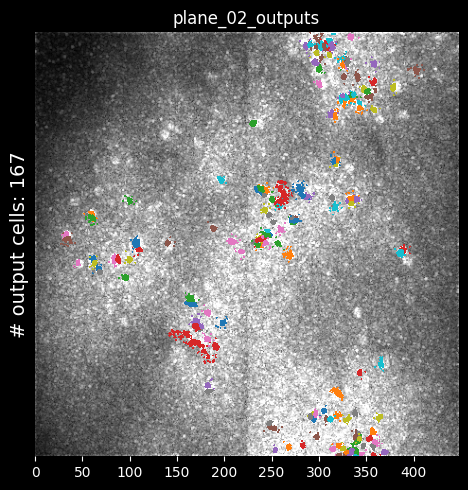

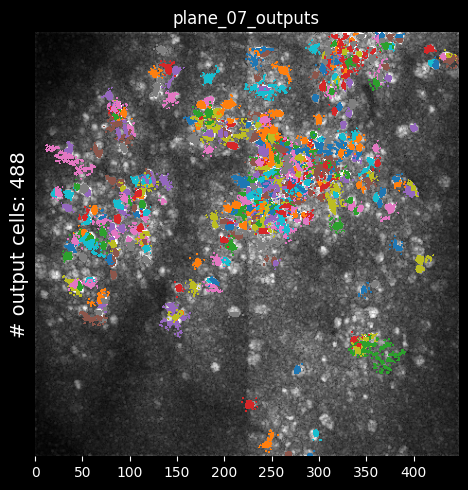

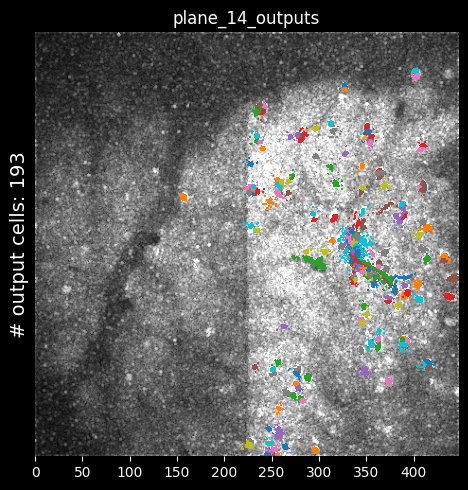

In [4]:
%matplotlib inline
files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract", 'h5', 2)
for i,f in enumerate(files):
    outputs = load_extract_outputs_h5(f)
    plot_output_masks(output=outputs, title=Path(f).stem)
    plt.show()

## Second parameter set

``` matlab 
config.downsample_time_by = 4;
config.spatial_lowpass_cutoff = 1;
config.cellfind_min_snr = 0;
config.thresholds.T_min_snr = 3.2;
config.thresholds.spatial_corrupt_thresh = 5;
config.thresholds.T_dup_corr_thresh = 0.8;
config.adaptive_kappa = 2;
config.kappa_std_ratio = 1;
```


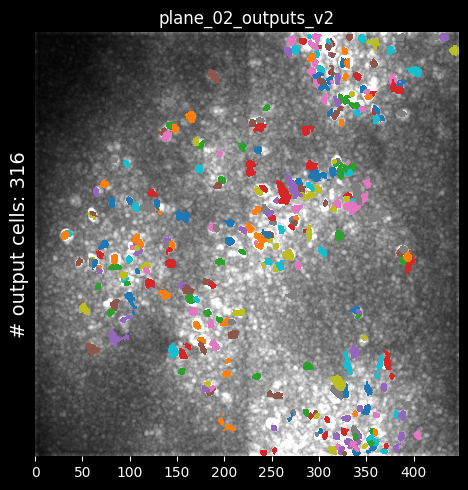

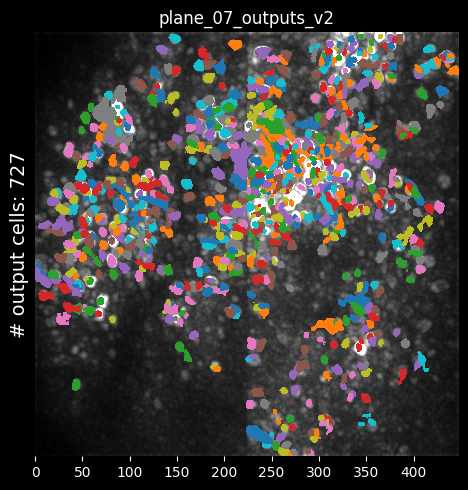

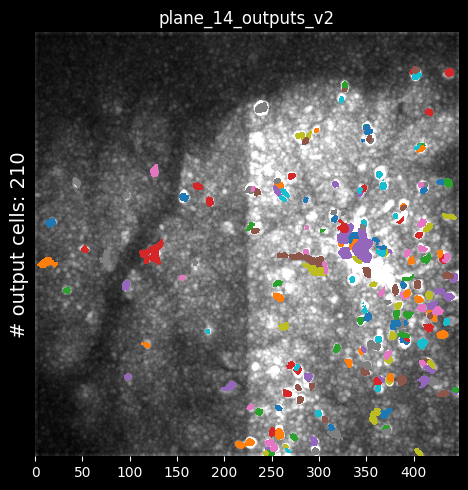

In [5]:
files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract_v2", 'h5', 2)
for f in files:
    outputs = load_extract_outputs_h5(f)
    plot_output_masks(output=outputs, title=Path(f).stem)
    plt.show()

## Comparison with Suite2p

In [6]:
files_s2p = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\mk301\results", "ops.npy", 3)
files_s2p[:4]

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_01_mk301\\plane0\\ops.npy',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_02_mk301\\plane0\\ops.npy',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_03_mk301\\plane0\\ops.npy',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_04_mk301\\plane0\\ops.npy']

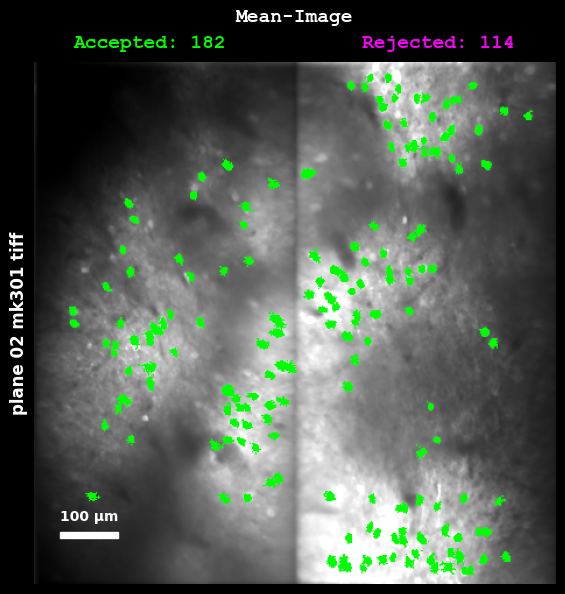

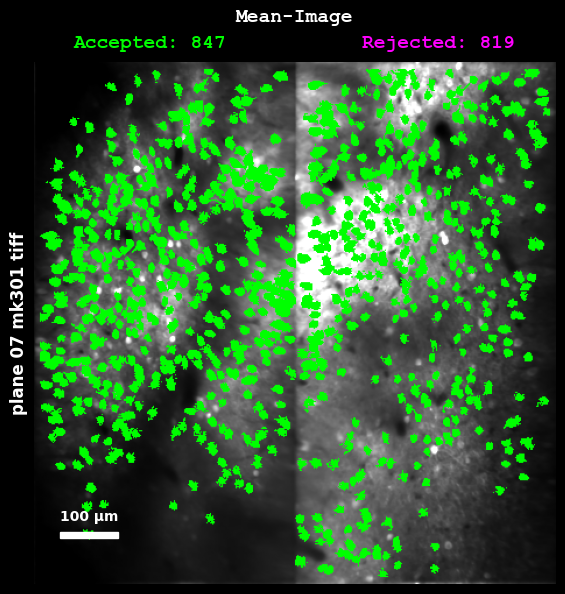

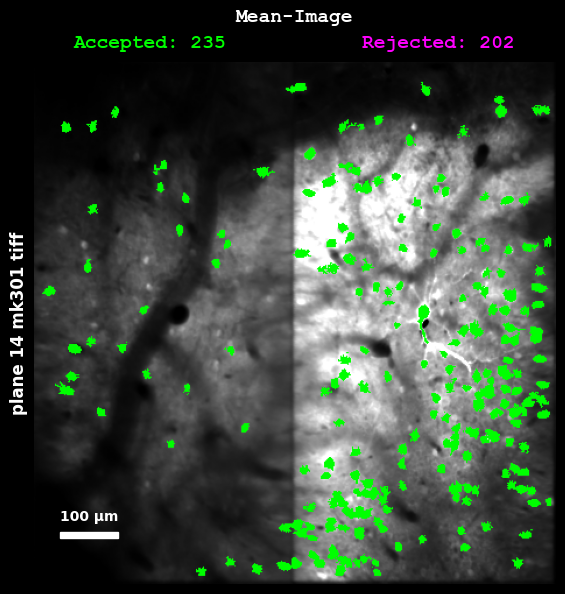

In [7]:
for i, f in enumerate(files_s2p):
    if i in [1, 6, 13]:
        op = lsp.load_ops(f)
        lsp.plot_projection(op, savepath="", add_scalebar=True, proj="meanImg", display_masks=True, accepted_only=True, fig_label=op["tiff_list"][0])

## Compute [Intersection over Union](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [8]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def iou_matrix(masksA, masksB):
    iou = np.zeros((len(masksA), len(masksB)))
    for i in range(len(masksA)):
        for j in range(len(masksB)):
            iou[i, j] = compute_iou(masksA[i], masksB[j])
    return iou

suite2p outputs

In [9]:
files_s2p[1]

'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_02_mk301\\plane0\\ops.npy'

In [10]:
ops = lsp.load_ops(files_s2p[1])
proj = "meanImg"

In [17]:
import suite2p

data = ops[proj]
shape = data.shape

stats_file = Path(ops['save_path']).joinpath('stat.npy')

iscell = np.load(Path(ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)[iscell]
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)

im[im == 0] = np.nan

assert im.shape[0] == len(stats)

extract outputs

In [18]:
files_extract = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract_v2", 'h5', 2)
output = load_extract_outputs_h5(files_extract[0])

info = output['info']
summary_image = info['summary_image']
spatial_weights = output['spatial_weights']
spatial_weights.shape
# plot_output_masks(output=outputs, title=Path(f).stem)

(316, 448, 448)

![IoU](../docs/_images/IoU.png)

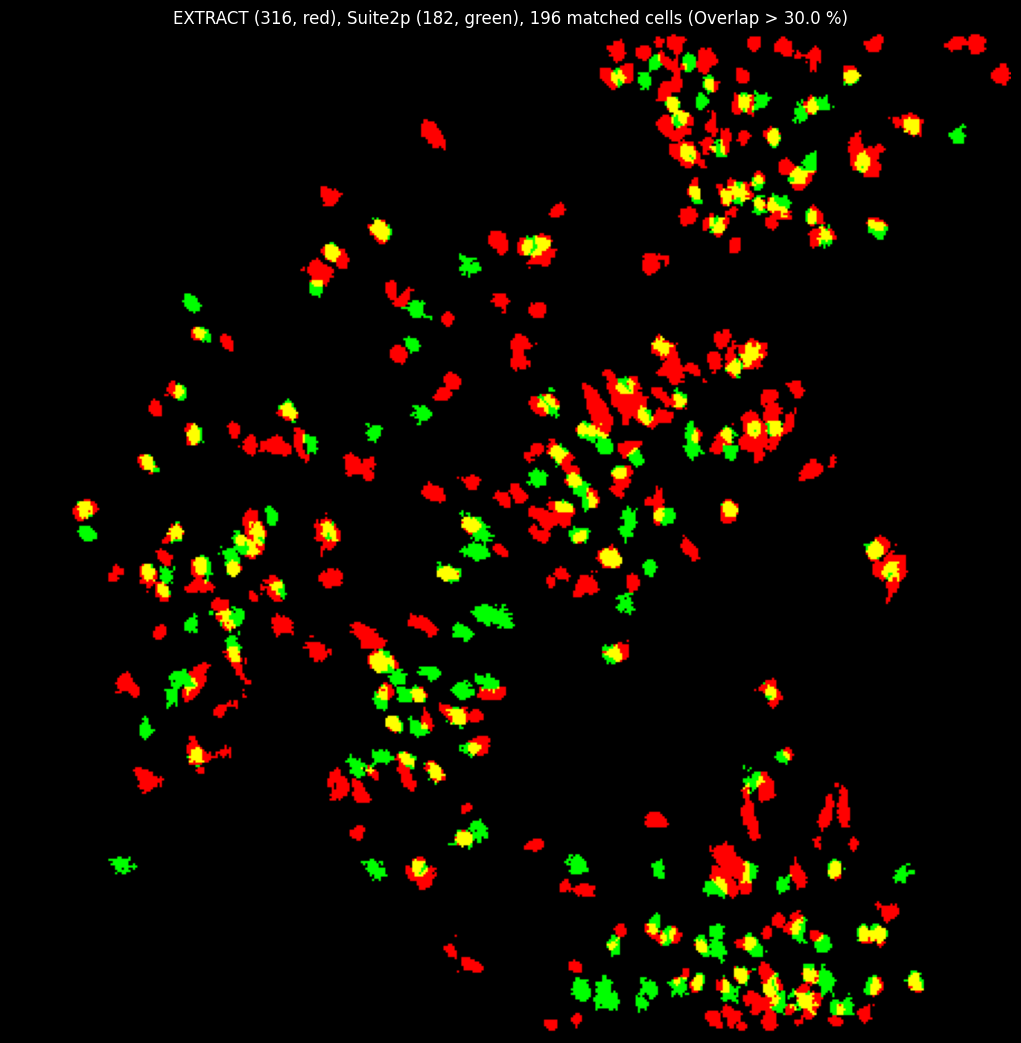

196 EXTRACT cells matched with Suite2p at IoU > 0.3


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

spatial_weights_bin = (spatial_weights > 0).astype(np.uint8)  # EXTRACT
im_bin = (~np.isnan(im)).astype(np.uint8)                     # Suite2p

# Dilation-based soft IoU
def compute_soft_iou(mask1, mask2, dilation_iter=2):
    m1 = binary_dilation(mask1, iterations=dilation_iter)
    m2 = binary_dilation(mask2, iterations=dilation_iter)
    intersection = np.logical_and(m1, m2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def iou_matrix_dilated(masksA, masksB, dilation_iter=2):
    nA, nB = masksA.shape[0], masksB.shape[0]
    iou = np.zeros((nA, nB))
    for i in range(nA):
        for j in range(nB):
            iou[i, j] = compute_soft_iou(masksA[i], masksB[j], dilation_iter)
    return iou

extract_masks = spatial_weights_bin
suite2p_masks = im
suite2p_masks = (im > 0).astype(np.uint8)

iou = iou_matrix_dilated(extract_masks, suite2p_masks)

extract_all = extract_masks.any(axis=0)
suite2p_all = suite2p_masks.any(axis=0)

overlay = np.zeros((*extract_all.shape, 3))
overlay[..., 0] = extract_all  # Red
overlay[..., 1] = suite2p_all  # Green

iou_max = 0.3
matches = np.max(iou, axis=1)
n_matches = np.sum(matches > 0.3)

plt.imshow(overlay)
plt.title("All EXTRACT (red) vs Suite2p (green)")
plt.title(f"EXTRACT ({spatial_weights_bin.shape[0]}, red), Suite2p ({im_bin.shape[0]}, green), {n_matches} matched cells (Overlap > {iou_max * 100} %)")

plt.axis("off")
plt.show()

print(f"{n_matches} EXTRACT cells matched with Suite2p at IoU > 0.3")

In [54]:
def compare_extract_suite2p_overlap(extract_h5, suite2p_ops_path, title=None, iou_thresh=0.3):
    outputs = load_extract_outputs_h5(extract_h5)
    info = outputs['info']
    spatial_weights = outputs['spatial_weights']
    summary_image = info['summary_image']
    vmin, vmax = np.quantile(summary_image, (0, 0.95))
    extract_bin = (spatial_weights > 0).astype(np.uint8)
    n_extract = extract_bin.shape[0]

    ops = lsp.load_ops(suite2p_ops_path)
    stat = np.load(Path(ops['save_path']) / 'stat.npy', allow_pickle=True)
    iscell = np.load(Path(ops['save_path']) / 'iscell.npy')[:, 0].astype(bool)
    im = suite2p.ROI.stats_dicts_to_3d_array(stat, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)
    im[np.isnan(im)] = 0
    suite2p_bin = (im > 0).astype(np.uint8)
    suite2p_accepted_bin = suite2p_bin[iscell]
    n_s2p = suite2p_accepted_bin.shape[0]

    iou = iou_matrix_dilated(extract_bin, suite2p_accepted_bin)
    matches = np.max(iou, axis=1)
    matched_mask = matches > iou_thresh
    n_matched = np.sum(matched_mask)

    extract_all = extract_bin.any(axis=0)
    s2p_all = suite2p_accepted_bin.any(axis=0)
    matched_overlay = extract_bin[matched_mask].any(axis=0)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for ax in axs: ax.axis("off")

    axs[0].imshow(summary_image, cmap="gray", vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("tab10")
    for i in range(n_extract):
        axs[0].contourf(extract_bin[i], levels=[0.5, 1], colors=[cmap(i % 10)], alpha=1)
    axs[0].set_title(f"EXTRACT ({n_extract})", fontsize=14)

    mean_img = ops["meanImg"]
    vmin_s2p, vmax_s2p = np.nanpercentile(mean_img, (2, 98))
    axs[1].imshow(mean_img, cmap="gray", vmin=vmin_s2p, vmax=vmax_s2p)
    green_overlay = np.zeros((*s2p_all.shape, 4))
    green_overlay[..., 1] = 1
    green_overlay[..., 3] = s2p_all
    axs[1].imshow(green_overlay)
    axs[1].set_title(f"Suite2p ({n_s2p})", fontsize=14)

    overlay = np.zeros((*s2p_all.shape, 3))
    overlay[..., 0] = extract_all
    overlay[..., 1] = s2p_all
    overlay[matched_overlay, :] = [1, 1, 1]  # yellow
    axs[2].imshow(overlay)
    axs[2].set_title(f"Matched: {n_matched} / {n_extract} @ IoU>{int(iou_thresh*100)}%", fontsize=14)

    if title:
        fig.suptitle(title, fontsize=16)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


In [55]:
files[0], files_s2p[1]

('D:\\W2_DATA\\kbarber\\2025_03_01\\assembled\\extract_v2\\plane_02_outputs_v2.h5',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\results\\plane_02_mk301\\plane0\\ops.npy')

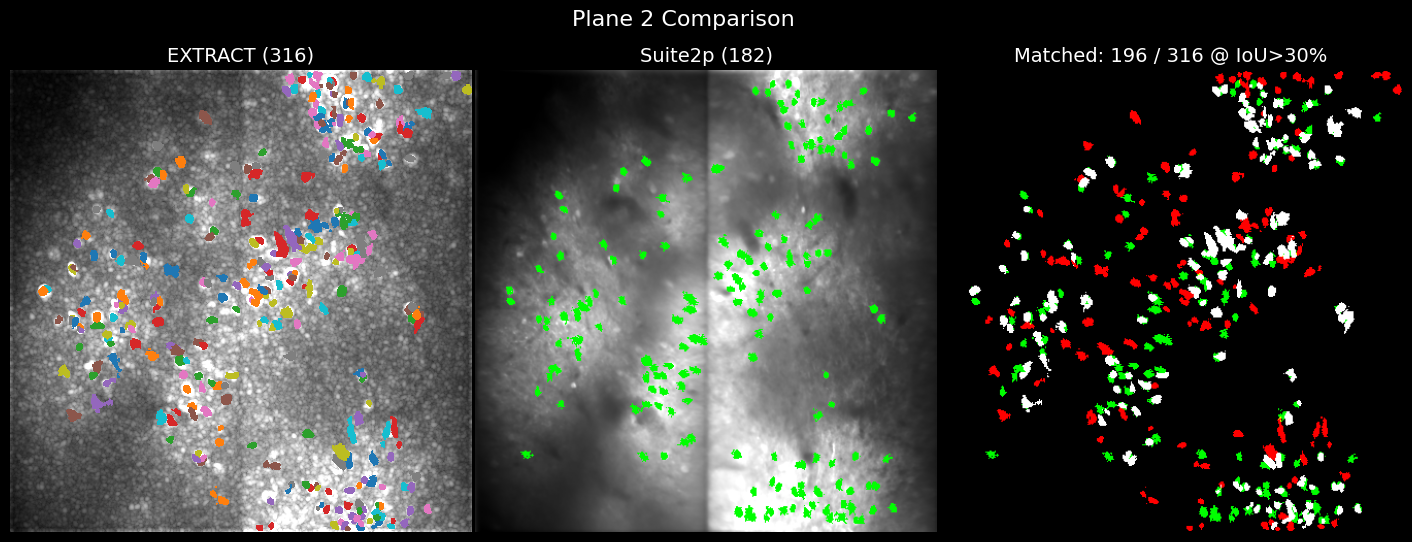

In [56]:
compare_extract_suite2p_overlap(files[0], files_s2p[1], title="Plane 2 Comparison")

## Problems

IoU is taking each EXTRACT cell, and finding if it matches *any* suite2p cell.
- This is why there are more matches than suite2p cells.
- Not 1:1, inflated number

Potential Solutions:

- Match with replacement, remove extract cell once its matched
- Find best match, only count that cell (multiple IoU for a single extract cell, use the highest)
- More advanced algorithms:
  - Hungarian algorithm: what self-driving cars use to track close-proximity vehicles

In [37]:
def compare_extract_suite2p_one_to_one(extract_h5, suite2p_ops_path, title=None, iou_thresh=0.3):
    outputs = load_extract_outputs_h5(extract_h5)
    info = outputs['info']
    spatial_weights = outputs['spatial_weights']
    summary_image = info['summary_image']
    vmin, vmax = np.quantile(summary_image, (0, 0.95))
    extract_bin = (spatial_weights > 0).astype(np.uint8)
    n_extract = extract_bin.shape[0]

    ops = lsp.load_ops(suite2p_ops_path)
    stat = np.load(Path(ops['save_path']) / 'stat.npy', allow_pickle=True)
    iscell = np.load(Path(ops['save_path']) / 'iscell.npy')[:, 0].astype(bool)
    im = suite2p.ROI.stats_dicts_to_3d_array(stat, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)
    im[np.isnan(im)] = 0
    suite2p_bin = (im > 0).astype(np.uint8)
    suite2p_accepted_bin = suite2p_bin[iscell]
    n_s2p = suite2p_accepted_bin.shape[0]

    iou = iou_matrix_dilated(extract_bin, suite2p_accepted_bin)
    matched_extract = []
    matched_s2p = set()

    for i in range(iou.shape[0]):
        j = np.argmax(iou[i])
        if iou[i, j] > iou_thresh and j not in matched_s2p:
            matched_extract.append((i, j))
            matched_s2p.add(j)

    n_matched = len(matched_extract)

    extract_overlay = np.zeros_like(extract_bin[0])
    s2p_overlay = np.zeros_like(suite2p_accepted_bin[0])
    overlap = np.zeros((*extract_overlay.shape, 3))

    for i, _ in matched_extract:
        extract_overlay |= extract_bin[i]
    for _, j in matched_extract:
        s2p_overlay |= suite2p_accepted_bin[j]

    overlap[..., 0] = extract_bin.any(axis=0)
    overlap[..., 1] = suite2p_accepted_bin.any(axis=0)
    overlap[(extract_overlay & s2p_overlay)] = [1, 1, 0]  # yellow for 1:1 matched

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for ax in axs: ax.axis("off")

    axs[0].imshow(summary_image, cmap="gray", vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("tab10")
    for i in range(n_extract):
        axs[0].contourf(extract_bin[i], levels=[0.5, 1], colors=[cmap(i % 10)], alpha=1)
    axs[0].set_title(f"EXTRACT ({n_extract})", fontsize=14)

    mean_img = ops["meanImg"]
    vmin_s2p, vmax_s2p = np.nanpercentile(mean_img, (2, 98))
    axs[1].imshow(mean_img, cmap="gray", vmin=vmin_s2p, vmax=vmax_s2p)
    green_overlay = np.zeros((*s2p_overlay.shape, 4))
    green_overlay[..., 1] = 1
    green_overlay[..., 3] = suite2p_accepted_bin.any(axis=0)
    axs[1].imshow(green_overlay)
    axs[1].set_title(f"Suite2p ({n_s2p})", fontsize=14)

    axs[2].imshow(overlap)
    axs[2].set_title(f"1:1 Matched: {n_matched}/{n_extract} @ IoU>{int(iou_thresh*100)}%", fontsize=14)

    if title:
        fig.suptitle(title, fontsize=16)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


I think this yellow line happens because of misaligned masks

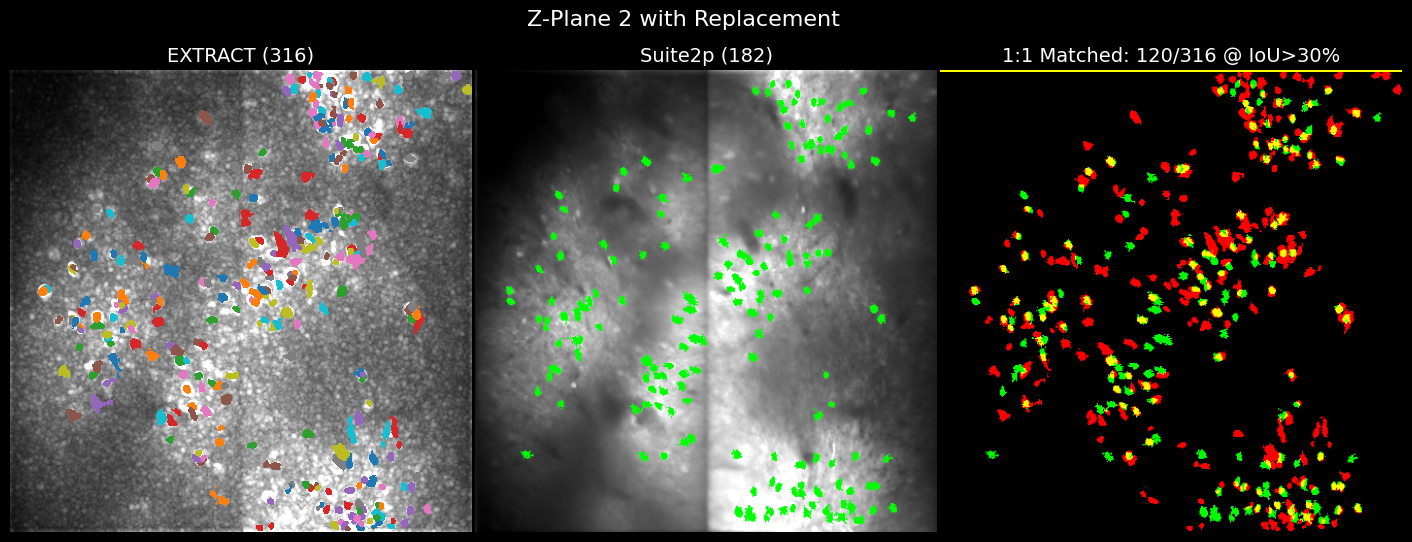

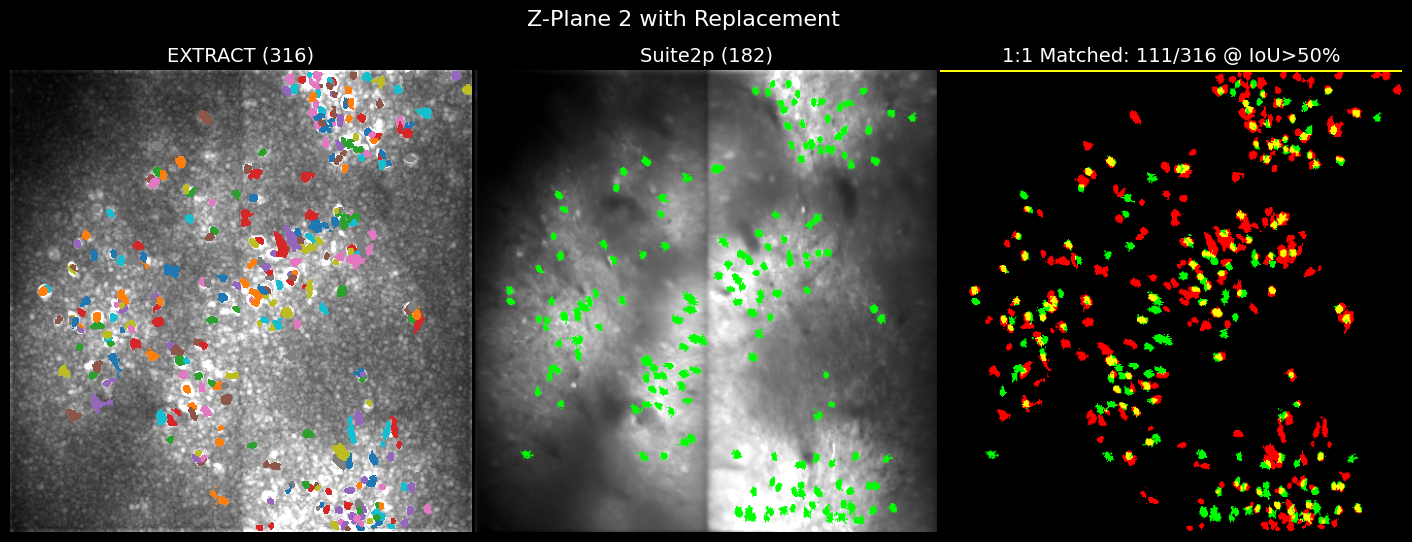

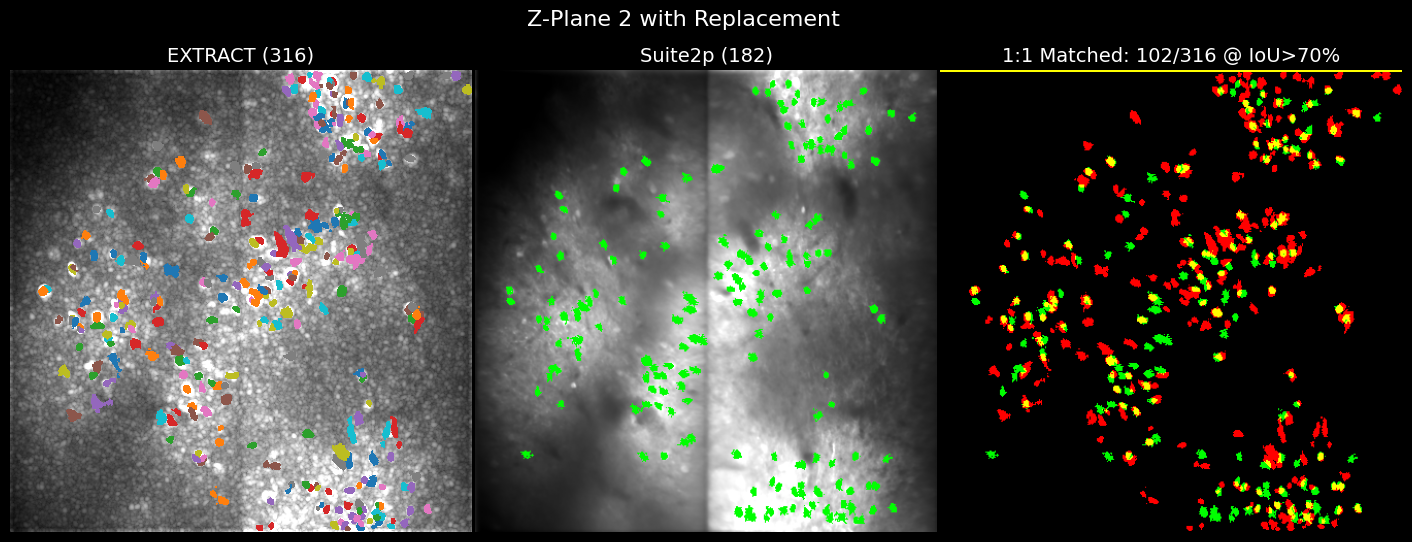

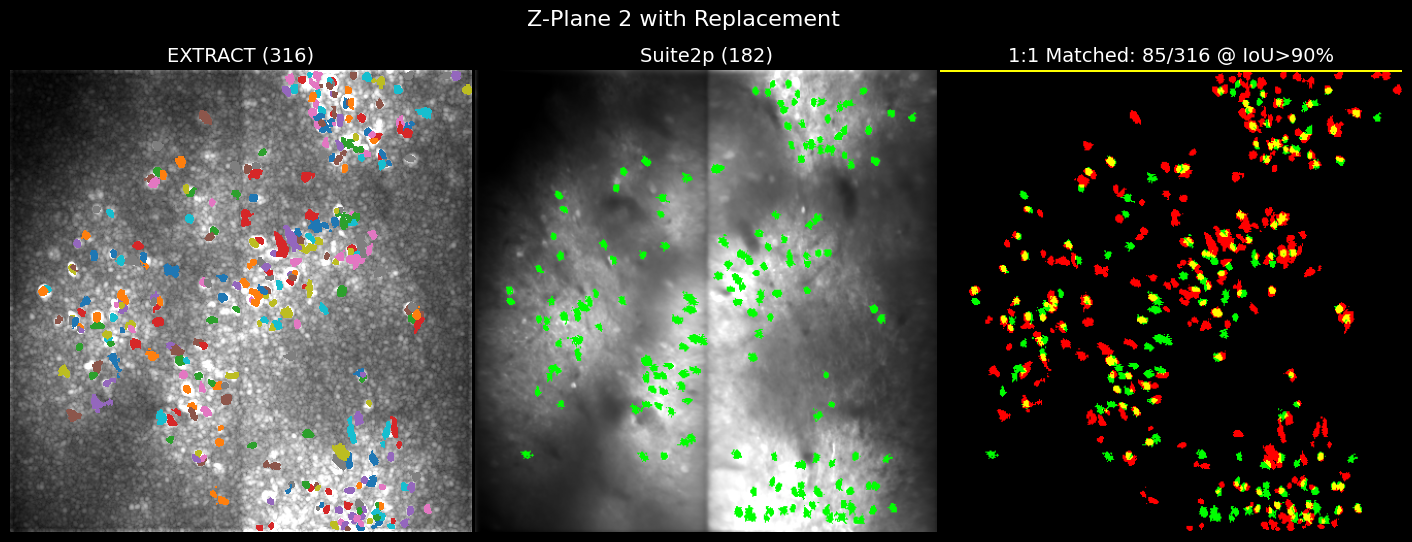

In [40]:
for thresh in [0.3, 0.5, 0.7, 0.9]:
    compare_extract_suite2p_one_to_one(files[0], files_s2p[1], iou_thresh=thresh, title="Z-Plane 2 with Replacement")

In [ ]:
matched_extract = []
used_extract = set()
used_suite2p = set()
threshold = 0.3

# sorrt all pairs by IoU descending
flat_indices = np.dstack(np.unravel_index(np.argsort(iou.ravel())[::-1], iou.shape))[0]

for i, j in flat_indices:
    if iou[i, j] > threshold and i not in used_extract and j not in used_suite2p:
        matched_extract.append((i, j))
        used_extract.add(i)
        used_suite2p.add(j)

In [ ]:
# (i_extract, j_suite2p)
overlapping_suite2p_indices = sorted(set(j for _, j in matched_extract))
suite2p_overlapping_cells = im[overlapping_suite2p_indices]

In [ ]:
matched_suite2p_indices = np.argmax(iou, axis=1)

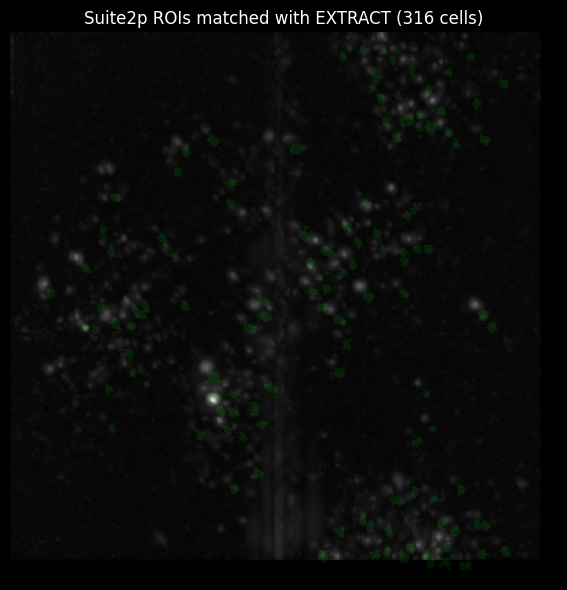

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

overlay = np.zeros((*suite2p_masks.shape[1:], 3))
matched_suite2p_masks = suite2p_masks[matched_suite2p_indices]

for mask in matched_suite2p_masks:
    overlay[..., 1] += mask

overlay[..., 1] = np.clip(overlay[..., 1], 0, 1)
background = ops['Vcorr']

plt.figure(figsize=(6, 6))
plt.imshow(background, cmap='gray', alpha=0.9)
plt.imshow(overlay, alpha=0.1)
plt.title(f"Suite2p ROIs matched with EXTRACT ({len(matched_suite2p_indices)} cells)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [52]:
import fastplotlib as fpl